preprocessing, libraries and data  

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf

def map_func(sample):
    image = sample['image']
    label = sample['label']
    label = tf.one_hot(label, 2, dtype=tf.float32)
    return image, label


ds1, ds2, ds3 = tfds.load('patch_camelyon',
                         split=['train[:20%]', 'test[:5%]', 'validation[:5%]'],
                         data_dir=r'C:\job_og_eksamensbevis\Github\projekter\Projekt_1_Computer_Vision\path_to_data_directory',
                         download=False,
                         shuffle_files=True)

train_dataset_cnn       = ds1.map(map_func).batch(32)
validation_dataset_cnn  = ds3.map(map_func).batch(32)
test_dataset_cnn        = ds2.map(map_func).batch(32)

Loading all the models to avoid error if network fails

In [1]:
from tensorflow.keras.applications import ResNet50V2, ResNet101, InceptionV3, DenseNet121, MobileNetV2, Xception, EfficientNetB0, EfficientNetB7

# Pre-download weights for ResNet50V2
ResNet50V2(weights='imagenet', include_top=False)

# Pre-download weights for ResNet101
ResNet101(weights='imagenet', include_top=False)

# Pre-download weights for InceptionV3
InceptionV3(weights='imagenet', include_top=False)

# Pre-download weights for DenseNet121
DenseNet121(weights='imagenet', include_top=False)

# Pre-download weights for MobileNetV2
MobileNetV2(weights='imagenet', include_top=False)

# Pre-download weights for Xception
Xception(weights='imagenet', include_top=False)

# Pre-download weights for EfficientNetB0
EfficientNetB0(weights='imagenet', include_top=False)

# Pre-download weights for EfficientNetB7
EfficientNetB7(weights='imagenet', include_top=False)

base transfer

In [ ]:
from tensorflow.keras.applications import EfficientNetB0,ResNet101,ResNet50V2
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model

def build_cnn_with_efficientnet(encoder_output_shape, num_classes):
    # Create an input layer that matches the output shape of the encoder
    cnn_input = Input(shape=encoder_output_shape)

    # Load the pre-trained EfficientNetB0 model, without the top layer (the classification head)
    base_model = EfficientNetB0(include_top=False, weights='imagenet', input_tensor=cnn_input)

    # Freeze the layers of the base model
    for layer in base_model.layers:
        layer.trainable = False

    # Add new layers on top of the base model
    x = base_model.output
    x = GlobalAveragePooling2D()(x)  # Add a global average pooling layer
    
    # Additional custom layers
    x = Dense(128, activation='relu')(x)
    
    # Output layer
    predictions = Dense(num_classes, activation='softmax')(x)

    # Create the final model
    model = Model(inputs=cnn_input, outputs=predictions)

    return model


Compiling and classifying

In [ ]:
# Example usage
input_shape = (96, 96, 3) 
num_classes = 2  

cnn_model = build_cnn_with_efficientnet(input_shape, num_classes)

cnn_model.compile(optimizer='adam',  
                  loss='categorical_crossentropy',  
                  metrics=['accuracy'])  

# Now you can train your model
history = cnn_model.fit(
    train_dataset_cnn,
    validation_data=validation_dataset_cnn,
    epochs=10,
    batch_size=32,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3)]
)

# And evaluate it
loss, accuracy = cnn_model.evaluate(test_dataset_cnn, verbose=1)


Visualizing

In [ ]:
# Access the training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

import matplotlib.pyplot as plt

# Plot for loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot for accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

Adjusted CNN to loop the different models

In [2]:
def build_cnn_with_base_model(base_model_func, input_shape, num_classes):
    cnn_input = Input(shape=input_shape)
    base_model = base_model_func(include_top=False, weights='imagenet', input_tensor=cnn_input)

    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=cnn_input, outputs=predictions)
    return model


Looping over the different models on  base model for transfer. 

Training and evaluating with base model: ResNet50V2


Epoch 1/5



1639/1639 [==============================] - 648s 386ms/step - loss: 3.6328 - accuracy: 0.7021 - val_loss: 1.0990 - val_accuracy: 0.6777
Epoch 2/5
1639/1639 [==============================] - 552s 337ms/step - loss: 0.8157 - accuracy: 0.7351 - val_loss: 0.4878 - val_accuracy: 0.7766
Epoch 3/5
1639/1639 [==============================] - 459s 280ms/step - loss: 0.5132 - accuracy: 0.7699 - val_loss: 0.4798 - val_accuracy: 0.7637
Epoch 4/5
1639/1639 [==============================] - 465s 283ms/step - loss: 0.4809 - accuracy: 0.7800 - val_loss: 0.4307 - val_accuracy: 0.8126
Epoch 5/5
52/52 [==============================] - 8s 161ms/step - loss: 0.5070 - accuracy: 0.7558
Training and evaluating with base model: ResNet101
Epoch 1/5
1639/1639 [==============================] - 671s 406ms/step - loss: 0.3784 - accuracy: 0.8317 - val_loss: 0.3627 - val_accuracy: 0.8407
Epoch 2/5
1639/1639 [==============================] - 661s 403ms/step - loss: 0.3112 - accuracy: 0.8650 - val_loss: 0.3760 -

Epoch 1/5
1639/1639 [==============================] - 117s 70ms/step - loss: 0.5464 - accuracy: 0.7463 - val_loss: 0.5646 - val_accuracy: 0.7076
Epoch 2/5
1639/1639 [==============================] - 114s 70ms/step - loss: 0.4988 - accuracy: 0.7628 - val_loss: 0.4929 - val_accuracy: 0.7753
Epoch 3/5
1639/1639 [==============================] - 116s 71ms/step - loss: 0.4909 - accuracy: 0.7654 - val_loss: 0.4792 - val_accuracy: 0.7821
Epoch 4/5
1639/1639 [==============================] - 110s 67ms/step - loss: 0.4834 - accuracy: 0.7700 - val_loss: 0.4668 - val_accuracy: 0.7888
Epoch 5/5
52/52 [==============================] - 4s 67ms/step - loss: 0.5388 - accuracy: 0.7198
Training and evaluating with base model: Xception
Epoch 1/5
1639/1639 [==============================] - 368s 223ms/step - loss: 0.6612 - accuracy: 0.7493 - val_loss: 0.4815 - val_accuracy: 0.7851
Epoch 2/5
1639/1639 [==============================] - 360s 219ms/step - loss: 0.4959 - accuracy: 0.7659 - val_loss: 0.45

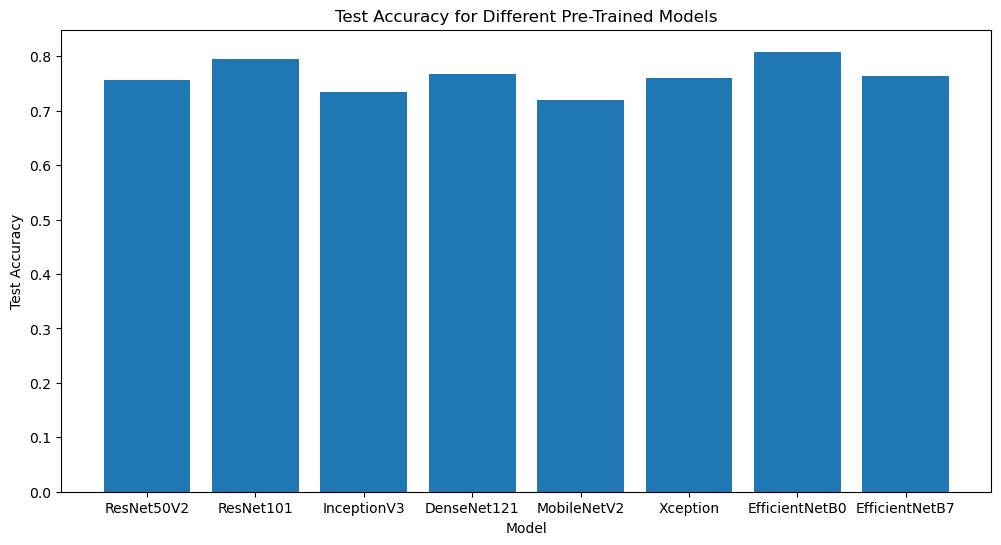

In [9]:
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Conv2D, MaxPooling2D, Flatten, Reshape, UpSampling2D, Dropout, Conv2DTranspose
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping

base_models = [ResNet50V2, ResNet101, InceptionV3, DenseNet121, MobileNetV2, Xception, EfficientNetB0, EfficientNetB7]
base_model_names = ['ResNet50V2', 'ResNet101', 'InceptionV3', 'DenseNet121', 'MobileNetV2', 'Xception', 'EfficientNetB0', 'EfficientNetB7']
results = []

input_shape = (96, 96, 3)  # Define the input shape
num_classes = 2  # Define the number of classes

for base_model, name in zip(base_models, base_model_names):
    print(f"Training and evaluating with base model: {name}")
    cnn_model = build_cnn_with_base_model(base_model, input_shape, num_classes)

    cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    history = cnn_model.fit(train_dataset_cnn, validation_data=validation_dataset_cnn, epochs=5, batch_size=32, callbacks=[EarlyStopping(monitor='val_loss', patience=3)], verbose=1)
    loss, accuracy = cnn_model.evaluate(test_dataset_cnn, verbose=1)
    results.append((name, accuracy))

# Plotting the results
plt.figure(figsize=(12, 6))
plt.bar([r[0] for r in results], [r[1] for r in results])
plt.xlabel('Model')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy for Different Pre-Trained Models')
plt.show()
